AdvNLP - HW1

-Clarice Mottet

# Outline

Part 1: Rule-based Analysis using spaCy Matcher (2 points)
- Objective: Utilize spaCy's Matcher to classify movie reviews as positive or negative based on predefined linguistic rules.
- Tasks:
  1. Positive Reviews Rule Creation (0.5 point): Develop a rule using spaCy's Matcher to identify phrases commonly found in positive reviews. Justify your choice of patterns.
  2. Negative Reviews Rule Creation (0.5 point): Create a similar rule for detecting negative reviews. Explain the rationale behind the patterns selected.
  3. Reducing False Positives (1 point): Propose and implement a rule to minimize false positives in your classifications. Discuss the improvements observed.

Part 2: Machine Learning with TF-IDF and Logistic Regression (3 points)
- Objective: Build and evaluate a sentiment analysis model using TF-IDF vectorization and logistic regression.
- Tasks:
  1. Model Fitting (0.5 points): Train a logistic regression model on TF-IDF vectors of the movie reviews.
  2. Feature Importance Analysis (0.5 points): Identify and interpret the most influential features in your model.
  3. Preprocessing Improvements (1 point): Experiment with different preprocessing techniques of your training set to enhance model performance. Summarize the impact of these modifications.
  4. Word2Vec Embeddings (0.5 points each for a. and b.):
     - a. Implement sentence embedding using the mean of word vectors and retrain your logistic regression model.
     - b. Create sentence embeddings using TF-IDF weighted averages of word vectors and retrain the model. Compare this approach with the mean embedding technique. Comment

Part 3: Recurrent Neural Networks (RNN) with Word2Vec (4 points)
- Objective: Explore the application of RNNs for sentiment analysis, utilizing pre-trained Word2Vec embeddings.
- Tasks:
  1. RNN Implementation (2 point): Fit an RNN model with LSTM units using Word2Vec embeddings. Analyze and compare its performance with the TF-IDF based logistic regression model. Discuss any notable differences in results.
  2. Word2Vec Vectors Analysis:
     - Before and After Fine-Tuning (1 point): Examine the evolution of word vectors by comparing them before and after fine-tuning on the movie review dataset. Provide insights into the changes observed.
     - Visualization and Commentary (1 point): Visualize the embeddings of select words before and after fine-tuning using a tool like t-SNE or PCA. Comment on any patterns or shifts in word associations.

Submission Guidelines:
- Document your code, analysis, and findings in a Jupyter notebook. 1 point on code quality
- Include comments and markdown cells to explain your logic and interpretations at each step.

- Submit the notebook file via colab.
- Dataset: https://huggingface.co/datasets/rotten_tomatoes

In [30]:
#libraries

import pandas as pd
import numpy as np
import os
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from datasets import load_dataset

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import spacy
from spacy.matcher import Matcher
# Load English tokenizer, tagger, parser, and NER
nlp = spacy.load("en_core_web_sm")

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import spacy

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from gensim.models import Word2Vec
# Optionally, you can train a TF-IDF model as well
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

path_ = r'/home/clarice/Documents/VSCode/Term2_AdvNLP/Homework1/AdvNLP_HW1/data'
os.listdir(path_)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clarice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/clarice/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clarice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['default_train_0000.parquet',
 'df_false_pos.xlsx',
 'default_test_0000.parquet',
 'df_features_logreg_stem.xlsx',
 'df_features_logreg.xlsx',
 'df_features_logreg_lemm.xlsx']

In [2]:
#professor defined functions

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

In [3]:
#user defined functions

# Function to preprocess text
def preprocess_text(text):

    #keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    #convert to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    # Load NLTK's English stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Remove common words in both populations
    both_pop_rmv = ["like","make","film","movie","one","little","good","enough","funny","many","much", "old"]
    tokens = [word for word in tokens if word.lower() not in both_pop_rmv]
    
    # # Stem using NLTK's Porter stemmer
    # Initialize NLTK's Porter stemmer
    # porter_stemmer = PorterStemmer()

    # stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]

    # # Lemmatize using spaCy
    # doc = nlp(" ".join(stemmed_tokens))
    # lemmatized_tokens = [token.lemma_ for token in doc]

    # Join the tokens back into a single string
    clean_text = " ".join(tokens)
    
    return clean_text

# Function to preprocess text
def preprocess_text_stemmed(text):

    #keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    #convert to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    # Load NLTK's English stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Remove common words in both populations
    both_pop_rmv = ["like","make","film","movie","one","little","good","enough","funny","many","much","old"]
    tokens = [word for word in tokens if word.lower() not in both_pop_rmv]
    
    # Stem using NLTK's Porter stemmer
    # Initialize NLTK's Porter stemmer
    porter_stemmer = PorterStemmer()

    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]

    # Join the tokens back into a single string
    clean_text = " ".join(stemmed_tokens)
    
    return clean_text

# Function to preprocess text
def preprocess_text_lemmatized(text):

    #keep only letters
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    #convert to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    # Load NLTK's English stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Remove common words in both populations
    both_pop_rmv = ["like","make","film","movie","one","little","good","enough","funny","many","much", "old"]
    tokens = [word for word in tokens if word.lower() not in both_pop_rmv]

    # Lemmatize using spaCy
    doc = nlp(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]

    # Join the tokens back into a single string
    clean_text = " ".join(lemmatized_tokens)
    
    return clean_text

In [4]:
#import and process data

# df_train = pd.read_parquet(path_+'//'+'default_train_0000.parquet')
# df_test = pd.read_parquet(path_+'//'+'default_test_0000.parquet')

#load data
dataset = load_dataset("rotten_tomatoes")

df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['validation'])

print("df_train size", len(df_train['text']))
# print(df_train.head())
print("df_test size", len(df_test['text']))
# print(df_test.head())
print("df_val size", len(df_val['text']))
# print(df_val.head())

#clean data

df_train['text'] = df_train['text'].str.lower().str.strip()
df_test['text'] = df_test['text'].str.lower().str.strip()
df_val['text'] = df_val['text'].str.lower().str.strip()

# Apply preprocessing to the 'text' column
df_train['text_clean'] = df_train['text'].apply(preprocess_text)
df_test['text_clean'] = df_test['text'].apply(preprocess_text)
df_val['text_clean'] = df_val['text'].apply(preprocess_text)

# print(df_train.head())

df_train size 8530
df_test size 1066
df_val size 1066


# Part 1: Rule-based Analysis using spaCy Matcher (2 points)
- Objective: Utilize spaCy's Matcher to classify movie reviews as positive or negative based on predefined linguistic rules.
- Tasks:
  1. Positive Reviews Rule Creation (0.5 point): Develop a rule using spaCy's Matcher to identify phrases commonly found in positive reviews. Justify your choice of patterns.
  2. Negative Reviews Rule Creation (0.5 point): Create a similar rule for detecting negative reviews. Explain the rationale behind the patterns selected.
  3. Reducing False Positives (1 point): Propose and implement a rule to minimize false positives in your classifications. Discuss the improvements observed.

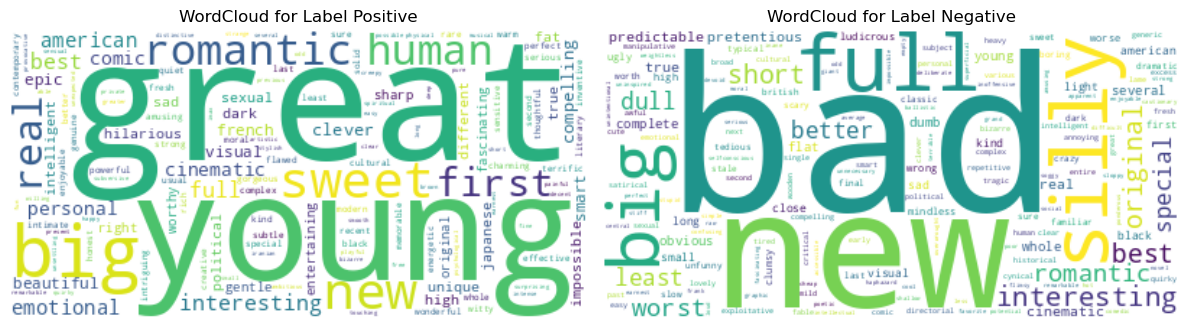

In [82]:
#create a word cloud of adjectives to create a vocabulary for matcher

stop_words = set(stopwords.words('english'))
labels = {0: 'Negative', 1: 'Positive'}

# Prepare data for wordclouds
label_data = defaultdict(lambda: '')

for text, label in zip(df_train['text_clean'], df_train['label']):
    doc = nlp(text)
    adjectives = [token.text for token in doc if token.pos_ == 'ADJ']
    label_data[label] += ' '.join(adjectives)

# Generate and plot wordclouds for each label
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create 1x2 subplots
axs = axs.flatten()  # Flatten the axis array

for ax, (label, text) in zip(axs, label_data.items()):
    wordcloud = WordCloud(stopwords=stop_words, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title('WordCloud for Label {}'.format(labels.get(label)))
    ax.axis('off')

plt.tight_layout()
plt.show()


In [5]:
# Initialize Matcher
matcher = Matcher(nlp.vocab)

# Define patterns for positive and negative reviews
positive_patterns = [
    [{"LOWER": "amazing"}],
    [{"LOWER": "fantastic"}],
    [{"LOWER": "great"}],
    [{"LOWER": "loved"}, {"POS": "VERB"}],
    [{"LOWER": "excellent"}],
    [{"LOWER": "sweet"}],
    [{"LOWER": "interesting"}],
    [{"LOWER": "perfect"}],
    [{"LOWER": "amusing"}],
    [{"LOWER": "beautiful"}],
    [{"LOWER": "unique"}],
    [{"LOWER": "terrific"}],
    [{"LOWER": "charming"}],
    [{"LOWER": "clever"}],
    [{"LOWER": "intelligent"}],
    [{"LOWER": "honesty"}],
    [{"LOWER": "imaginative"}],
    [{"LOWER": "realistic"}],
    [{"LOWER": "gorgeous"}],
    [{"LOWER": "witty"}]
]

negative_patterns = [
    [{"LOWER": "terrible"}],
    [{"LOWER": "awful"}],
    [{"LOWER": "hate"}, {"POS": "VERB"}],
    [{"LOWER": "dislike"}, {"POS": "VERB"}],
    [{"LOWER": "waste"}, {"LOWER": "of"}, {"LOWER": "time"}],
    [{"LOWER": "silly"}],
    [{"LOWER": "bad"}],
    # [{"LOWER": "old"}],
    [{"LOWER": "dull"}],
    [{"LOWER": "worst"}],
    [{"LOWER": "heavy"}],
    [{"LOWER": "least"}],
    [{"LOWER": "predictable"}],
    [{"LOWER": "unfunny"}],
    [{"LOWER": "tedious"}],
    [{"LOWER": "bad"}],
    [{"LOWER": "obvious"}],
    [{"LOWER": "pretentious"}],
    [{"LOWER": "ugly"}],
    [{"LOWER": "boring"}]
]

# Add patterns to matcher
for pattern in positive_patterns:
    matcher.add("Positive", [pattern])

for pattern in negative_patterns:
    matcher.add("Negative", [pattern])

# Function to classify review
def classify_review(text):
    doc = nlp(text)
    matches = matcher(doc)
    if any(match[0] == nlp.vocab.strings["Positive"] for match in matches):
        return 1  # Positive
    elif any(match[0] == nlp.vocab.strings["Negative"] for match in matches):
        return 0  # Negative
    else:
        return None  # Neutral or not determined

# Apply classification function to each review
df_train['predicted_label'] = df_train['text_clean'].apply(classify_review)

df_view = df_train[df_train['predicted_label'].isna()].copy()
print("df_train no match",len(df_view['text']))


df_train no match 7174


To determine an initial positive and negative rule creation, we cleaned the text data to lowercase everything and remove stopwords. Next, we created a word cloud to get a sense of what are the common terms used in positive and negative reviews. Through the wordcloud, we created a list to remove common terms found in both positive review and negative review populations. Words in the below list appeared often in both populations but do no lend information as to whether a review is positive or negative and are removed. ["like","make","film","movie","one","little","good","enough","funny","many","much","old]
Next we only looked at adjective words to drill down to terms than can be used to indicate positive or negative review in the wordcloud and developed an initial vocabulary.

With more time to work on this project, we would create a broader vocabularly to cover the full population but with time constraint, we only managed to cover approximately 1,500 reviews out of approximately 8,500.

In [6]:
#Analyze confusion matrix

df_pred = df_train[df_train['predicted_label'].notna()].copy()
df_pred.reset_index(drop = True, inplace = True)

cndn = (df_pred['label']==1)&(df_pred['predicted_label']==1)
print("True Positive Review:", len(df_pred[cndn]))

cndn = (df_pred['label']==1)&(df_pred['predicted_label']==0)
print("False Positive Review:", len(df_pred[cndn]['text']))

cndn = (df_pred['label']==0)&(df_pred['predicted_label']==0)
print("True Negative Review:", len(df_pred[cndn]['text']))

cndn = (df_pred['label']==0)&(df_pred['predicted_label']==1)
print("False Negative Review:", len(df_pred[cndn]['text']))

df_false_pos = df_train[(df_train['label']==1)&(df_train['predicted_label']==0)].copy()
print(df_false_pos['text_clean'].head())

# df_false_pos.to_excel(path_ + '//' + 'df_false_pos.xlsx')

True Positive Review: 494
False Positive Review: 127
True Negative Review: 505
False Negative Review: 230
39     bond outings recent years stunts outlandish bo...
67     part charm satin rouge avoids obvious humour l...
159    mysteries transparently obvious slowly paced t...
179    maybe past year seen release worst comedies de...
231    polished korean politicalaction bad hollywood ...
Name: text_clean, dtype: object


Initial Confusion Matrix:
True Positive Review: 470
False Positive Review: 221
True Negative Review: 564
False Negative Review: 231

After Update Confusion Matrix:
True Positive Review: 494
False Positive Review: 127
True Negative Review: 505
False Negative Review: 230

Upon analyzing the false positives, we see a common trend that the term "old" is often used in the context of describing the age of characters within a positive review, not that a movie is "old" in the context of uninteresting. This term is used as a negative marker and should be removed. We also incorporated more distinct positive terms to counteract potential false positives. We see with this update that we go from 221 false positives to 127 false positives, a reduction of approximately 40%.

# Part 2: Machine Learning with TF-IDF and Logistic Regression (3 points)
- Objective: Build and evaluate a sentiment analysis model using TF-IDF vectorization and logistic regression.
- Tasks:
  1. Model Fitting (0.5 points): Train a logistic regression model on TF-IDF vectors of the movie reviews.
  2. Feature Importance Analysis (0.5 points): Identify and interpret the most influential features in your model.
  3. Preprocessing Improvements (1 point): Experiment with different preprocessing techniques of your training set to enhance model performance. Summarize the impact of these modifications.
  4. Word2Vec Embeddings (0.5 points each for a. and b.):
     - a. Implement sentence embedding using the mean of word vectors and retrain your logistic regression model.
     - b. Create sentence embeddings using TF-IDF weighted averages of word vectors and retrain the model. Compare this approach with the mean embedding technique. Comment

In [7]:
#model fitting and training logistic regression model and feature importance

# Create a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),
                              min_df=5,
                              stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear')),
])

# Fit the pipeline on the training data
pipeline.fit(df_train['text_clean'], df_train['label'])

df_train['predicted_label_logreg'] = pipeline.predict(df_train['text_clean'])
df_test['predicted_label_logreg'] = pipeline.predict(df_test['text_clean'])

# Define a function to get the feature names from the TfidfVectorizer
def get_feature_names(model):
    try:
        return model.named_steps['tfidf'].get_feature_names_out()
    except AttributeError:
        return model.named_steps['tfidf'].get_feature_names()
    
# Get feature names
feature_names = get_feature_names(pipeline)

# Get coefficients of the logistic regression model
coefficients = pipeline.named_steps['clf'].coef_[0]

df_features = pd.DataFrame({'term': feature_names, 'coeff': coefficients})
df_features['coeff_abs'] = df_features['coeff'].abs()
df_features['importance'] = df_features['coeff_abs']/df_features['coeff_abs'].max()
df_features.sort_values(by = ['importance'], ascending = False, inplace = True)
df_features.reset_index(drop = True, inplace = True)
df_features = df_features[['term','importance']]

print("Number of terms used:",len(df_features['term']))

print("20 Most Importance Terms:")
print(df_features.head(20))

# df_features.to_excel(path_ + '//' + 'df_features_logreg.xlsx')

metrics_val= Metrics()
metrics_val.run(df_train['label'], df_train['predicted_label_logreg'], "basic TF-IDF")

metrics_val_test= Metrics()
metrics_val_test.run(df_test['label'], df_test['predicted_label_logreg'], "basic TF-IDF")

Number of terms used: 3663
20 Most Importance Terms:
            term  importance
0            bad    1.000000
1           dull    0.864977
2   performances    0.851938
3         boring    0.784380
4          feels    0.751270
5      enjoyable    0.712641
6          worst    0.707429
7       touching    0.703790
8        culture    0.688411
9         cinema    0.687028
10         fails    0.685113
11          flat    0.674977
12      portrait    0.672361
13           fun    0.668487
14     beautiful    0.659129
15     wonderful    0.649685
16     hilarious    0.637382
17    engrossing    0.636846
18         solid    0.632163
19      provides    0.611329


Using minimal cleaning of making everything lowercase, the removal of stopwords, the removal of common terms between both populations, and min_df = 5 (meaning the term has to appear in at least 5 reviews) we see that in building a logistic regression model the top 20 terms that are the biggest drivers to predict whether a review is positive or negative relates to terms that we would expect to see, terms that indicate a negative review such as "bad", "dull" or "boring" and terms that indicate a positive review such as "enjoyable", "touching", or "beautiful". We see that within the top twenty terms, the importance (or magnitude of coefficients) goes from 1 to .65 leading us to believe that the importance of terms is not concentrated to a small number of terms but is spread out over many terms.

In [8]:
#apply stemming and lemmatizing to data and create model

df_train['text_clean_stem'] = df_train['text'].apply(preprocess_text_stemmed)
df_test['text_clean_stem'] = df_test['text'].apply(preprocess_text_stemmed)
df_train['text_clean_lemm'] = df_train['text'].apply(preprocess_text_lemmatized)
df_test['text_clean_lemm'] = df_test['text'].apply(preprocess_text_lemmatized)

# Create a pipeline with TF-IDF and Logistic Regression
pipeline_stem = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),
                              min_df=5,
                              stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear')),
])

pipeline_lemm = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2),
                              min_df=5,
                              stop_words='english')),
    ('clf', LogisticRegression(solver='liblinear')),
])

# Fit the pipeline on the training data
pipeline_stem.fit(df_train['text_clean_stem'], df_train['label'])
pipeline_lemm.fit(df_train['text_clean_lemm'], df_train['label'])

df_train['predicted_label_logreg_stem'] = pipeline_stem.predict(df_train['text_clean_stem'])
df_train['predicted_label_logreg_lemm'] = pipeline_lemm.predict(df_train['text_clean_lemm'])

df_test['predicted_label_logreg_stem'] = pipeline_stem.predict(df_test['text_clean_stem'])
df_test['predicted_label_logreg_lemm'] = pipeline_lemm.predict(df_test['text_clean_lemm'])

# Get feature names
feature_names_stem = get_feature_names(pipeline_stem)
feature_names_lemm = get_feature_names(pipeline_lemm)

# Get coefficients of the logistic regression model
coefficients_stem = pipeline_stem.named_steps['clf'].coef_[0]
coefficients_lemm = pipeline_lemm.named_steps['clf'].coef_[0]

df_features_stem = pd.DataFrame({'term': feature_names_stem, 'coeff': coefficients_stem})
df_features_stem['coeff_abs'] = df_features_stem['coeff'].abs()
df_features_stem['importance'] = df_features_stem['coeff_abs']/df_features_stem['coeff_abs'].max()
df_features_stem.sort_values(by = ['importance'], ascending = False, inplace = True)
df_features_stem.reset_index(drop = True, inplace = True)
df_features_stem = df_features_stem[['term','importance']]

df_features_lemm = pd.DataFrame({'term': feature_names_lemm, 'coeff': coefficients_lemm})
df_features_lemm['coeff_abs'] = df_features_lemm['coeff'].abs()
df_features_lemm['importance'] = df_features_lemm['coeff_abs']/df_features_lemm['coeff_abs'].max()
df_features_lemm.sort_values(by = ['importance'], ascending = False, inplace = True)
df_features_lemm.reset_index(drop = True, inplace = True)
df_features_lemm = df_features_lemm[['term','importance']]

print("Number of terms used: stemmed:",len(df_features_stem['term']))
print("10 Most Importance Terms: stemmed:")
print(df_features_stem.head(10))
print("---------------------")
print("Number of terms used: lemmatized:",len(df_features_lemm['term']))
print("10 Most Importance Terms: lemmatized:")
print(df_features_lemm.head(10))

# df_features_stem.to_excel(path_ + '//' + 'df_features_logreg_stem.xlsx')
# df_features_lemm.to_excel(path_ + '//' + 'df_features_logreg_lemm.xlsx')

metrics_val.run(df_train['label'], df_train['predicted_label_logreg_stem'], "basic TF-IDF - stemmed")
metrics_val.run(df_train['label'], df_train['predicted_label_logreg_lemm'], "basic TF-IDF - lemmatized")

metrics_val_test.run(df_test['label'], df_test['predicted_label_logreg_stem'], "basic TF-IDF - stemmed")
metrics_val_test.run(df_test['label'], df_test['predicted_label_logreg_lemm'], "basic TF-IDF - lemmatized")

Number of terms used: stemmed: 3368
10 Most Importance Terms: stemmed:
      term  importance
0      bad    1.000000
1     bore    0.946314
2     dull    0.913744
3   beauti    0.911640
4     fail    0.775452
5  perform    0.763490
6     lack    0.741327
7   cultur    0.713672
8     wast    0.708411
9    worst    0.704529
---------------------
Number of terms used: lemmatized: 3381
10 Most Importance Terms: lemmatized:
          term  importance
0          bad    1.000000
1         dull    0.726585
2  performance    0.647153
3    enjoyable    0.613809
4      culture    0.606169
5         fail    0.598610
6    beautiful    0.589981
7         flat    0.587765
8         lack    0.584104
9       boring    0.577574


With regard to feature importance, we see that there are changes in the amount of terms and term importance between the different preprocessing steps. When we incorporate a stemming preprocessing step we go from 3850 terms to 3516 terms. We see that the term "bore" enters importance potential going from bored to bore but we don't see a too large overall change in terms of feature importance. With regard to incorporating a lemmatizing preprocessing step, we go from 3850 terms to 3562 terms. again we don't see too much of a change in terms of feature importance.

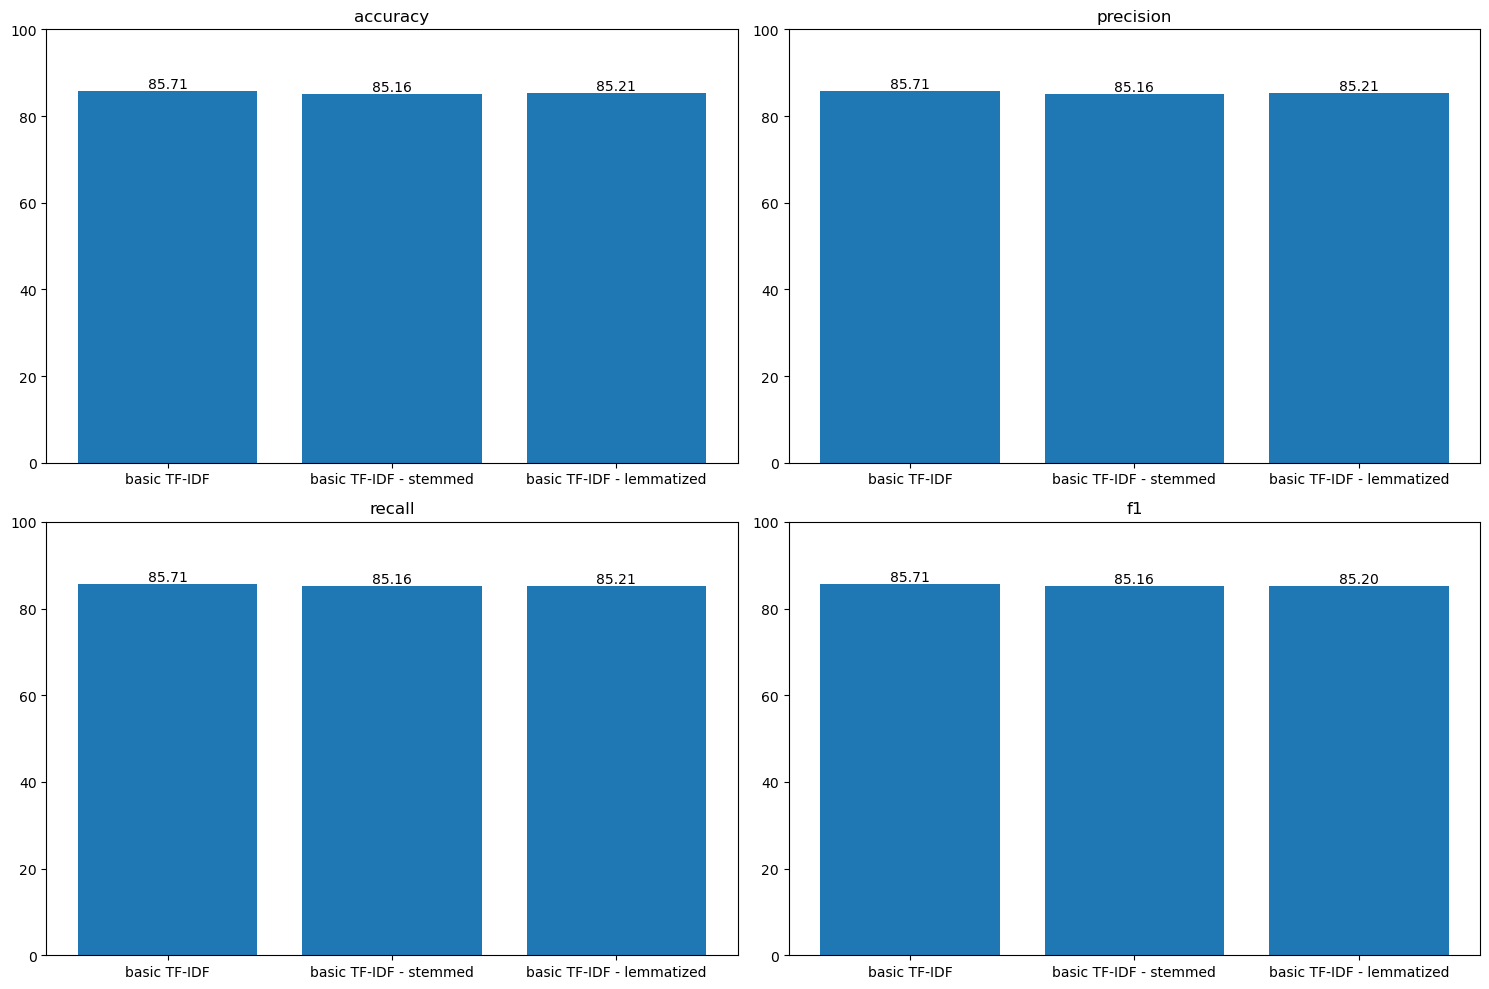

In [9]:
metrics_val.plot()

Looking at the performance metrics of the models we see that they all perform similarly across all metrics but the model with only stopwords removed offers the best results.

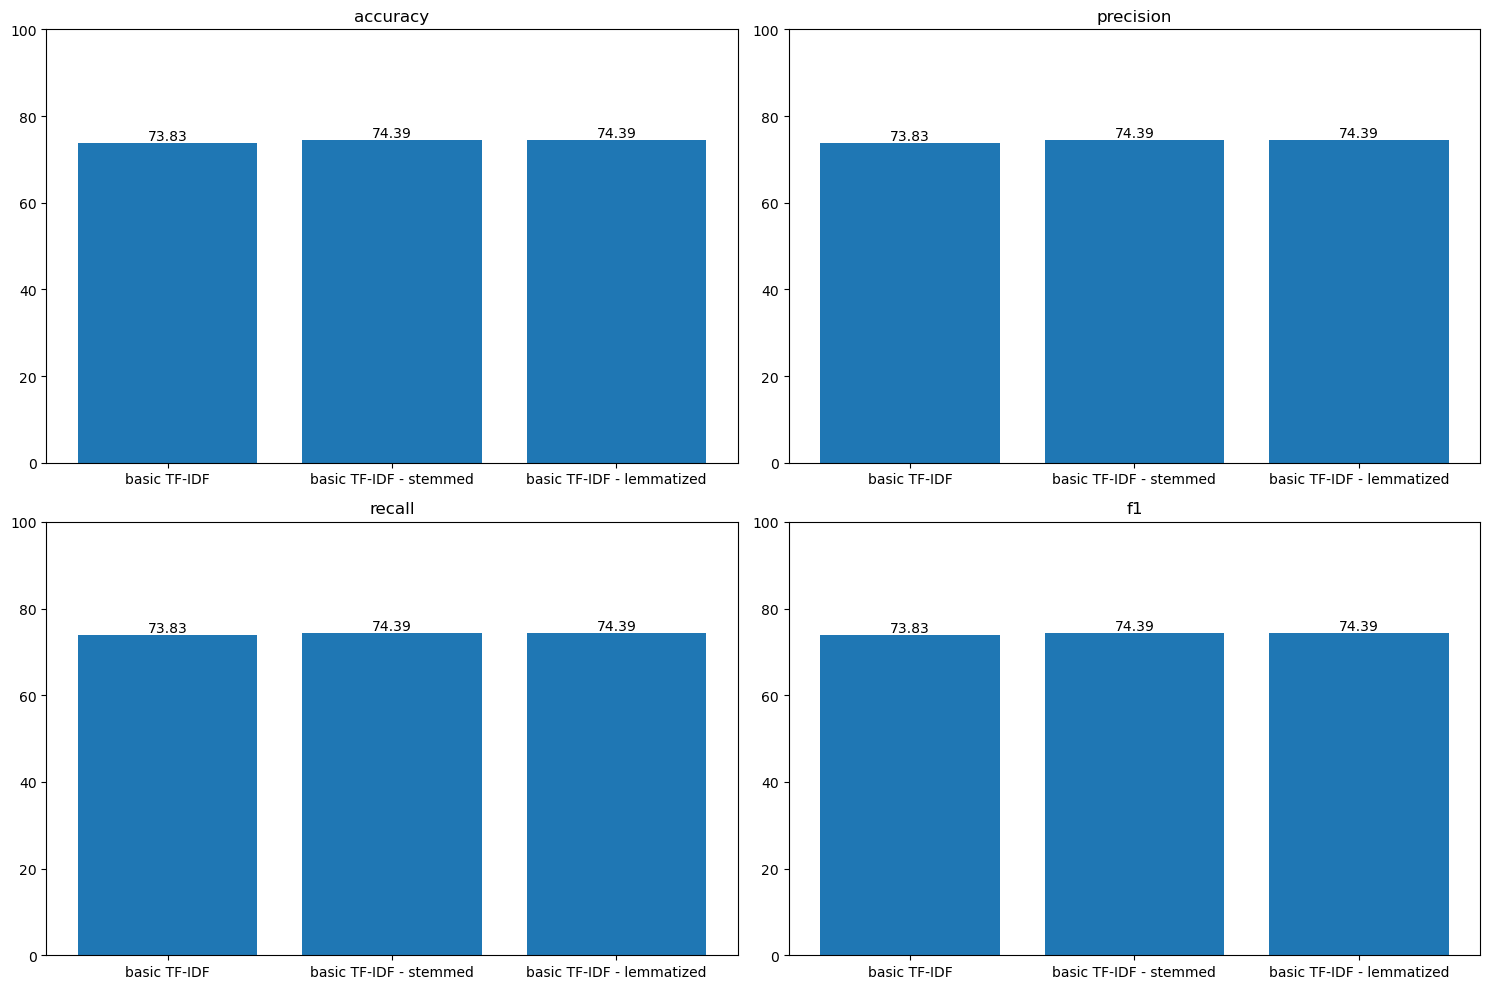

In [10]:
metrics_val_test.plot()

We see that in comparison of the test performance metrics vs the train performance metrics that the scores generally drop by about 10% indicating some overfitting to the training data. If I had more time, I would incorprate a gridsearch to determine the best parameters for the model to try and correct for this.

In [11]:
#incorporate word2vec embeddings

sentences = [text.split() for text in df_train['text_clean']]

# Train Word2Vec model
word2vec_model_ = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4)

dictionary = Dictionary(sentences)
corpus = [dictionary.doc2bow(sentence) for sentence in sentences]
tfidf_model = TfidfModel(corpus)

# Compute sentence embeddings using the mean of word vectors
def mean_word_vectors(sentences, model):
    vectors = []
    for sentence in sentences:
        tokens = sentence.split()
        word_vectors = []
        for token in tokens:
            if token in model.wv:
                word_vectors.append(model.wv[token])
        if word_vectors:
            sentence_vector = np.mean(word_vectors, axis=0)
            vectors.append(sentence_vector)
        else:
            vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)

# Convert text into Bag of Words representation
def text_to_bow(text, dictionary):
    tokens = text.split()
    bow = dictionary.doc2bow(tokens)
    return bow

# Create sentence embeddings using TF-IDF weighted averages of word vectors
def tfidf_weighted_word_vectors(sentences, model, tfidf_model, dictionary):
    vectors = []
    for sentence in sentences:
        bow = text_to_bow(sentence, dictionary)
        word_vectors = []
        for token_id, token_weight in bow:
            token = dictionary[token_id]
            if token in model.wv:
                tfidf_weight = tfidf_model[bow][0][1]  # Extract tfidf weight for the token
                word_vectors.append(model.wv[token] * tfidf_weight)
        if word_vectors:
            sentence_vector = np.mean(word_vectors, axis=0)
            vectors.append(sentence_vector)
        else:
            vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)

# Compute sentence embeddings
sentence_embeddings_mean = mean_word_vectors(df_train['text_clean'], word2vec_model_)
sentence_embeddings_tfidf = tfidf_weighted_word_vectors(df_train['text_clean'], word2vec_model_, tfidf_model, dictionary)

sentence_embeddings_mean_test = mean_word_vectors(df_test['text_clean'], word2vec_model_)
sentence_embeddings_tfidf_test = tfidf_weighted_word_vectors(df_test['text_clean'], word2vec_model_, tfidf_model, dictionary)

# Create a pipeline with Logistic Regression
pipeline_mean = Pipeline([
    ('clf', LogisticRegression(solver='liblinear')),
])

pipeline_tfidf = Pipeline([
    ('clf', LogisticRegression(solver='liblinear')),
])

# Fit the pipeline on the training data
pipeline_mean.fit(sentence_embeddings_mean, df_train['label'])
pipeline_tfidf.fit(sentence_embeddings_tfidf, df_train['label'])

# Make predictions
df_train['predicted_label_logreg_mean'] = pipeline_mean.predict(sentence_embeddings_mean)
df_train['predicted_label_logreg_tfidf'] = pipeline_tfidf.predict(sentence_embeddings_tfidf)

df_test['predicted_label_logreg_mean'] = pipeline_mean.predict(sentence_embeddings_mean_test)
df_test['predicted_label_logreg_tfidf'] = pipeline_tfidf.predict(sentence_embeddings_tfidf_test)

metrics_val.run(df_train['label'], df_train['predicted_label_logreg_mean'], "Word2Vec - mean")
metrics_val.run(df_train['label'], df_train['predicted_label_logreg_tfidf'], "word2Vec - tfidf")

metrics_val_test.run(df_test['label'], df_test['predicted_label_logreg_mean'], "Word2Vec - mean")
metrics_val_test.run(df_test['label'], df_test['predicted_label_logreg_tfidf'], "Word2Vec - tfidf")


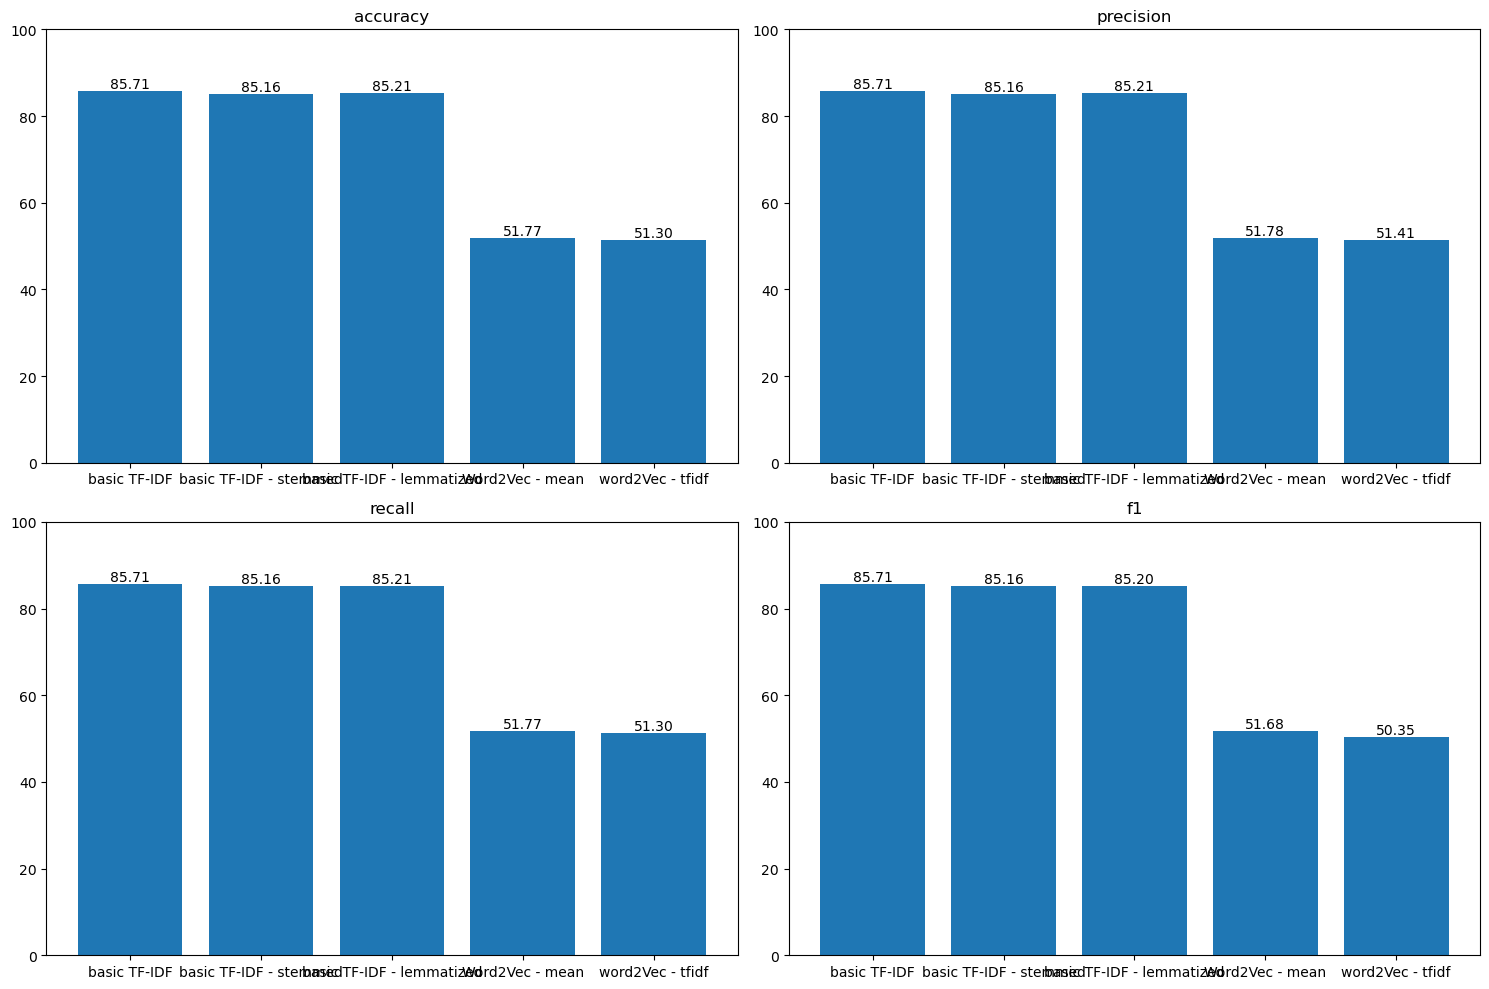

In [12]:
metrics_val.plot()

We see that using the word2vec methods we're achieving worse performance results. Practically similar performance to just guessing whether a review is a positive or negative review. Again I'd like to incorporate a way to investigate as to why this is happening, have grid search CV to determine best parameters and tune the model better but I don't have the time to make that update.

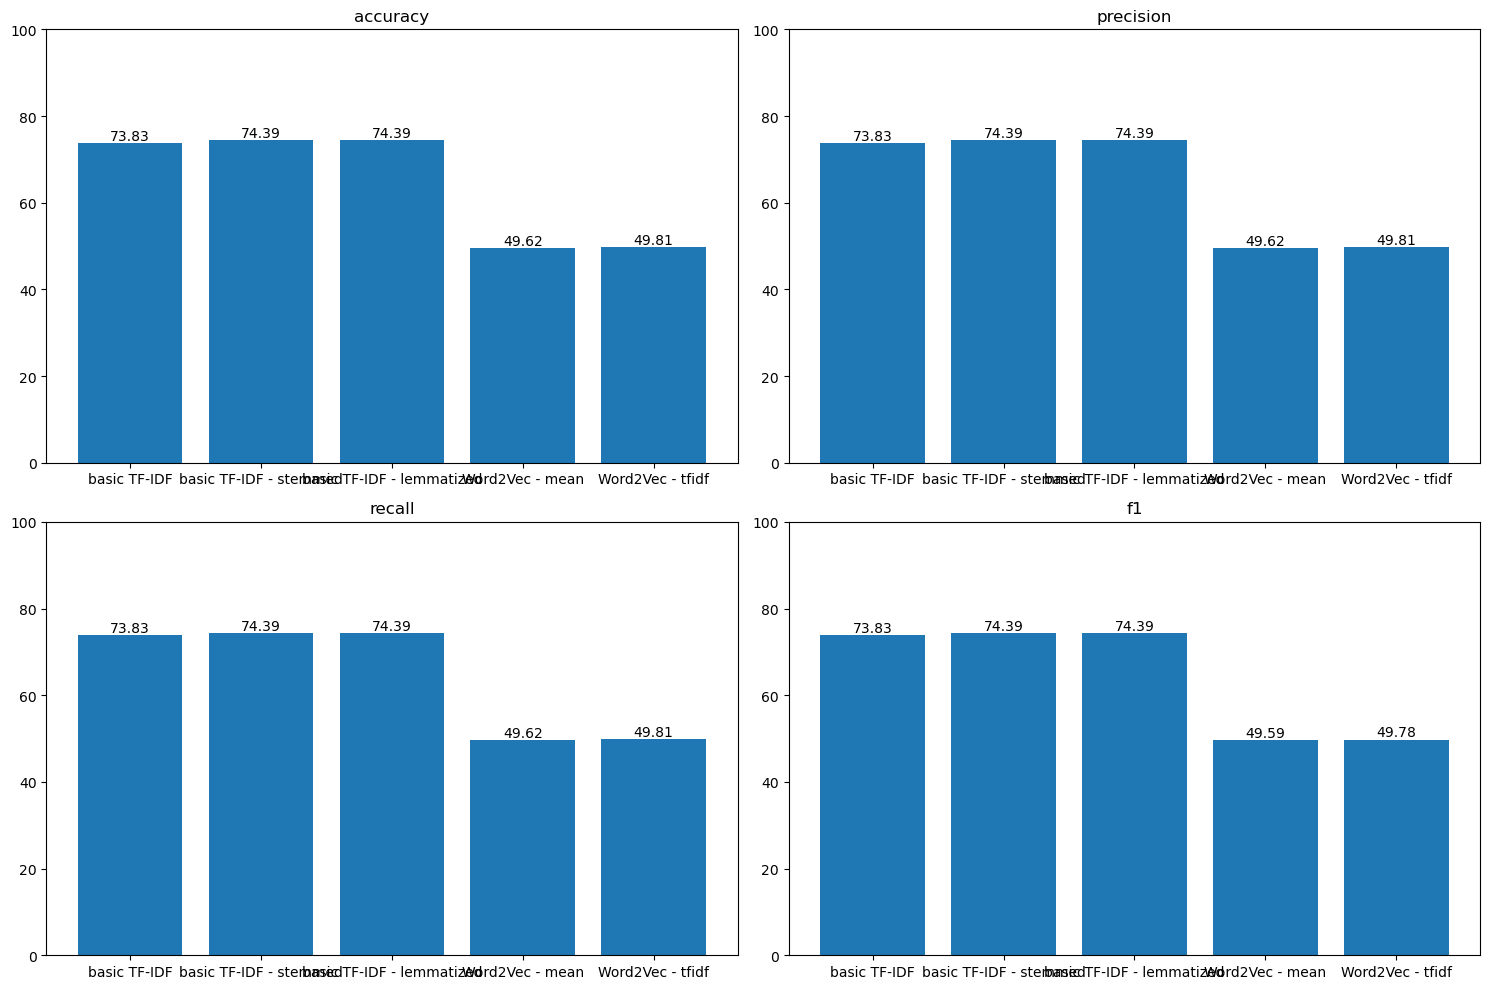

In [13]:
metrics_val_test.plot()

We see that the word2vec methods perform more consistently than the other methods between the training and test data yet still performs worse. Both word2vec methods perform similarly which is close to just guessing whether a review is positive or negative (50%)

# Part 3: Recurrent Neural Networks (RNN) with Word2Vec (4 points)
- Objective: Explore the application of RNNs for sentiment analysis, utilizing pre-trained Word2Vec embeddings.
- Tasks:
  1. RNN Implementation (2 point): Fit an RNN model with LSTM units using Word2Vec embeddings. Analyze and compare its performance with the TF-IDF based logistic regression model. Discuss any notable differences in results.
  2. Word2Vec Vectors Analysis:
     - Before and After Fine-Tuning (1 point): Examine the evolution of word vectors by comparing them before and after fine-tuning on the movie review dataset. Provide insights into the changes observed.
     - Visualization and Commentary (1 point): Visualize the embeddings of select words before and after fine-tuning using a tool like t-SNE or PCA. Comment on any patterns or shifts in word associations.

In [14]:
# load the pre-trained model
word2vec_model = api.load("word2vec-google-news-300")

print(word2vec_model)

KeyedVectors<vector_size=300, 3000000 keys>


The Kernel crashed while executing code in the current cell or a previous cell. 
Please review the code in the cell(s) to identify a possible cause of the failure. 
Click here for more info. 
View Jupyter log for further details.

First pass RNN model with LSTM units using Word2Vec embeddings. 

In [34]:
#get data into word2vec structure with pre-trained model

#set parameters
vocab_size = 3500 #previously we've seen there's approx 3.5k terms
max_length = 200
#initialize tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
#fit tokenizer on train_data
tokenizer.fit_on_texts(df_train['text_clean'])

#create word index
word_index = tokenizer.word_index

#this is to convert data to sequences of numbers, pad_sequences ensures each sequence is the same length
sequences_train = tokenizer.texts_to_sequences(df_train['text_clean'])
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_length, padding='post', truncating='post')

#same for test data
sequences_test = tokenizer.texts_to_sequences(df_test['text_clean'])
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

#same for validation data
sequences_val = tokenizer.texts_to_sequences(df_val['text_clean'])
padded_sequences_val = pad_sequences(sequences_val, maxlen=max_length, padding='post', truncating='post')

#convert train_labels and test_labels to np arrays
train_labels = np.array(df_train['label'])
test_labels = np.array(df_test['label'])
val_labels = np.array(df_val['label'])

# The code sets up an embedding matrix that will be loaded into an embedding layer
# in a deep learning model, ensuring that the words in your dataset are represented by
# their corresponding Word2Vec vectors. 

# Initialize model
my_model = Word2Vec(vector_size=300, min_count=1)  # size should match the dimensionality of pre-trained vectors

# Build vocabulary from your corpus
my_model.build_vocab(sequences_train)

# Update vocabulary with pre-trained model
my_model.build_vocab([list(word2vec_model.key_to_index)], update=True)

sequences_train_words = [[tokenizer.index_word[i] for i in seq] for seq in sequences_train]

# Fine-tune the model on your data
my_model.train(sequences_train_words, total_examples=len(sequences_train_words), epochs=5)

embedding_dim = 300

embedding_matrix = np.zeros(((vocab_size + 1), 300))

# Fill in the matrix
for word, i in tokenizer.word_index.items():
    if word in my_model.wv and i < vocab_size:
        embedding_vector = my_model.wv[word]
        embedding_matrix[i] = embedding_vector

: 

In [16]:
#build RNN model

# Set learning rate
learning_rate_ = 0.001

# Define the RNN model
model = Sequential([
    # First layer sets the size of the vocabulary and embedding dimensions using the embedding_matrix
    Embedding((vocab_size + 1), 300, weights=[embedding_matrix],
              input_length=max_length, trainable=False),  # Set trainable to False since the model is already pre-trained
    # Add LSTM layer with 64 units, including dropout and recurrent dropout (to prevent overfitting)
    Bidirectional(LSTM(64, dropout=.5, recurrent_dropout=.5, return_sequences=True)),
    # Second LSTM layer
    Bidirectional(LSTM(32, dropout=.5, recurrent_dropout=.5)),
    # Dense layers
    Dense(units=32, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=learning_rate_), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          1050300   
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          186880    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 6

In [17]:
# Setup early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # How many epochs to wait after min has been hit
    verbose=1,  # Verbosity level
    mode='min',  # Mode for the monitored quantity (minimizing loss)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

#use the validation data to guard against overfitting to the trainign data
history = model.fit(
    padded_sequences_train,
    train_labels,
    epochs=20,
    batch_size=128,
    validation_data=(padded_sequences_val, val_labels),
    callbacks=[early_stopping]
)


Epoch 1/20
67/67 [==============================] - 61s 796ms/step - loss: 0.6130 - accuracy: 0.6678 - val_loss: 0.5307 - val_accuracy: 0.7308
Epoch 2/20
67/67 [==============================] - 56s 829ms/step - loss: 0.5535 - accuracy: 0.7121 - val_loss: 0.5385 - val_accuracy: 0.7205
Epoch 3/20
67/67 [==============================] - 56s 831ms/step - loss: 0.5380 - accuracy: 0.7177 - val_loss: 0.5151 - val_accuracy: 0.7317
Epoch 4/20
67/67 [==============================] - 56s 833ms/step - loss: 0.5235 - accuracy: 0.7287 - val_loss: 0.5068 - val_accuracy: 0.7439
Epoch 5/20
67/67 [==============================] - 56s 834ms/step - loss: 0.5176 - accuracy: 0.7409 - val_loss: 0.5052 - val_accuracy: 0.7448
Epoch 6/20
67/67 [==============================] - 56s 835ms/step - loss: 0.5167 - accuracy: 0.7408 - val_loss: 0.5068 - val_accuracy: 0.7420
Epoch 7/20
67/67 [==============================] - 56s 836ms/step - loss: 0.5073 - accuracy: 0.7445 - val_loss: 0.5074 - val_accuracy: 0.7355

In [18]:
#see what the performance is

predictions_train = model.predict(padded_sequences_train)
train_preds = np.argmax(predictions_train, axis=1)

predictions_test = model.predict(padded_sequences_test)
test_preds = np.argmax(predictions_test, axis=1)

metrics_val.run(train_labels, train_preds, "BiLSTM + fine-tuned W2V")

metrics_val_test.run(test_labels, test_preds, "BiLSTM + fine-tuned W2V")

34/34 [==============================] - 2s 62ms/step


/home/clarice/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/clarice/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


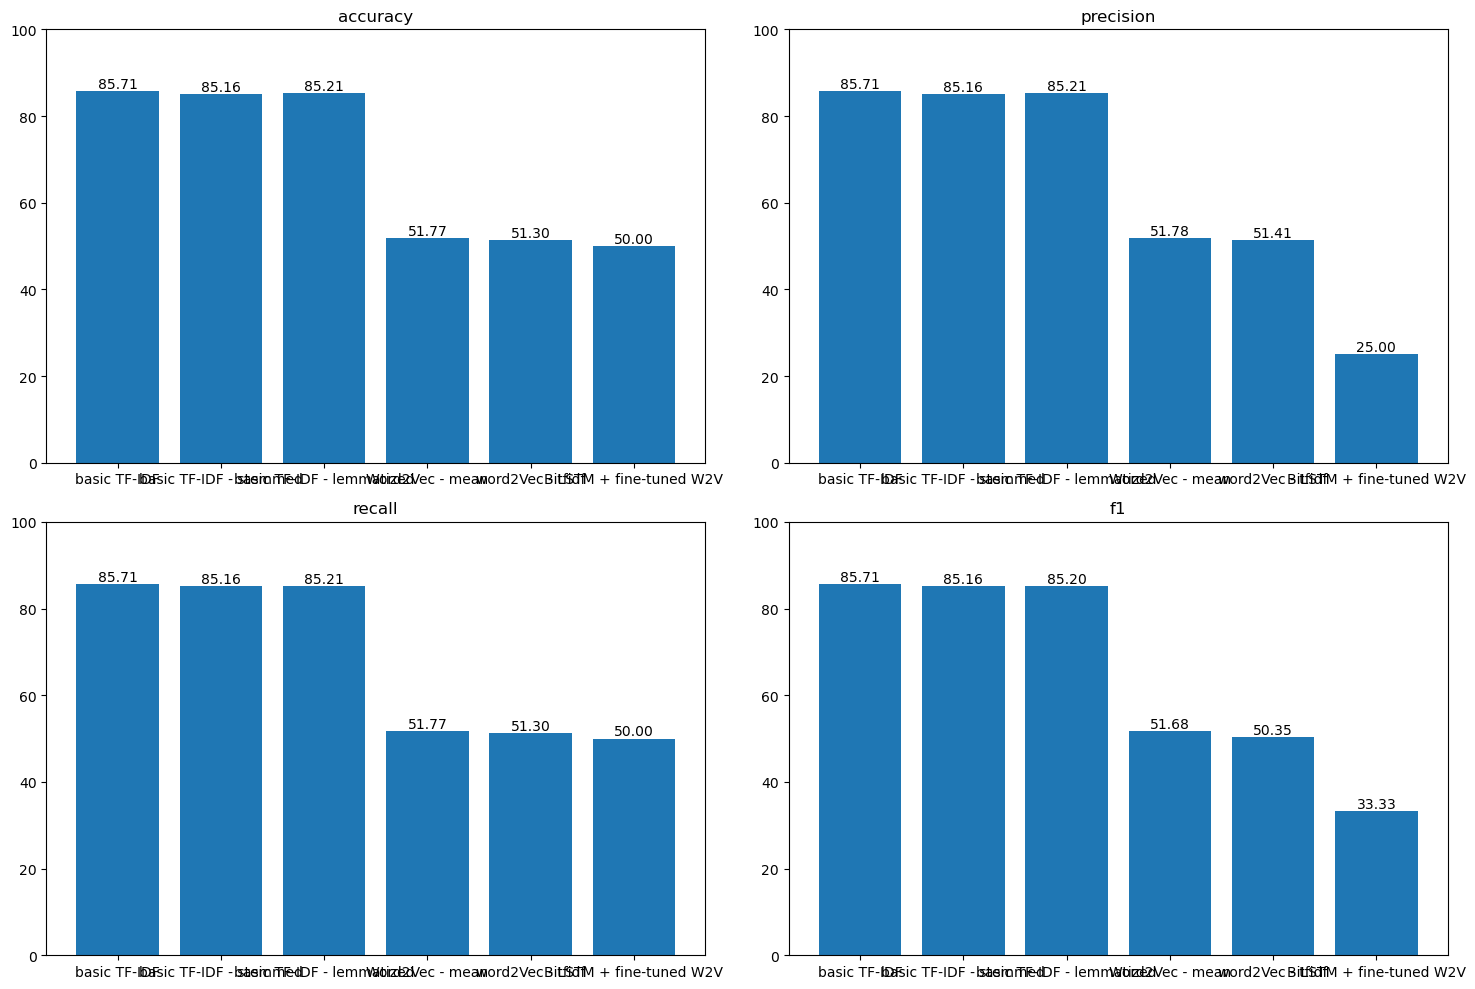

In [19]:
metrics_val.plot()

When we compare the NN model to the simple logistic model we see that the logistic model performs way better. I'm still not quite sure why my word2vec methods are performing so much worse than a more simple method.

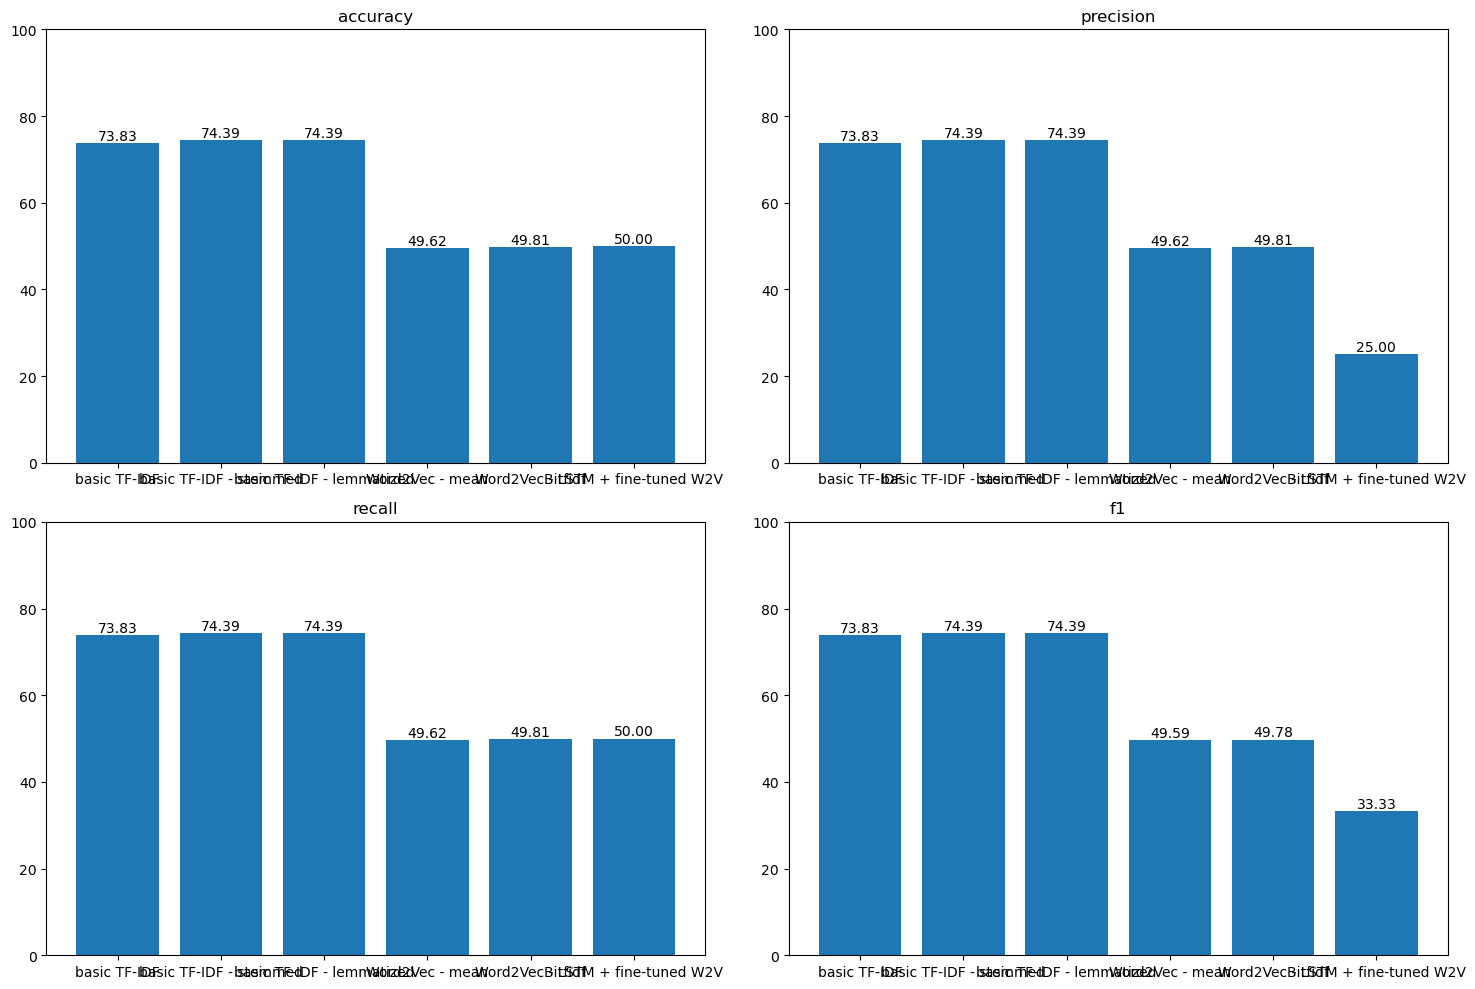

In [20]:
metrics_val_test.plot()

On the test data, we see that the NN performs the exact same as on the training data but it still performs much worse than the logistic regression models.

In [31]:
# used words from the above to visualize
words = [
    "amazing", "fantastic", "great", "loved", "excellent", "sweet",
    "interesting", "perfect", "amusing", "beautiful", "unique", "terrific",
    "charming", "clever", "intelligent", "honesty", "imaginative", "realistic",
    "gorgeous", "witty", "terrible", "awful", "hate", "dislike", "waste",
    "silly", "bad", "dull", "worst", "heavy", "least", "predictable", "unfunny",
    "tedious", "obvious", "pretentious", "ugly", "boring"]

# Extract their vectors from your model
word_vectors = np.array([my_model.wv[word] for word in words if word in my_model.wv])
w2v = np.array([word2vec_model[word] for word in words if word in word2vec_model])

# Apply t-SNE to word vectors
tsne_fine = TSNE(n_components=2, random_state=0)
word_vectors_2d = tsne_fine.fit_transform(word_vectors)

tsne = TSNE(n_components=2, random_state=0)
w2v_vectors_2d = tsne.fit_transform(w2v)


AttributeError: 'Sequential' object has no attribute 'wv'

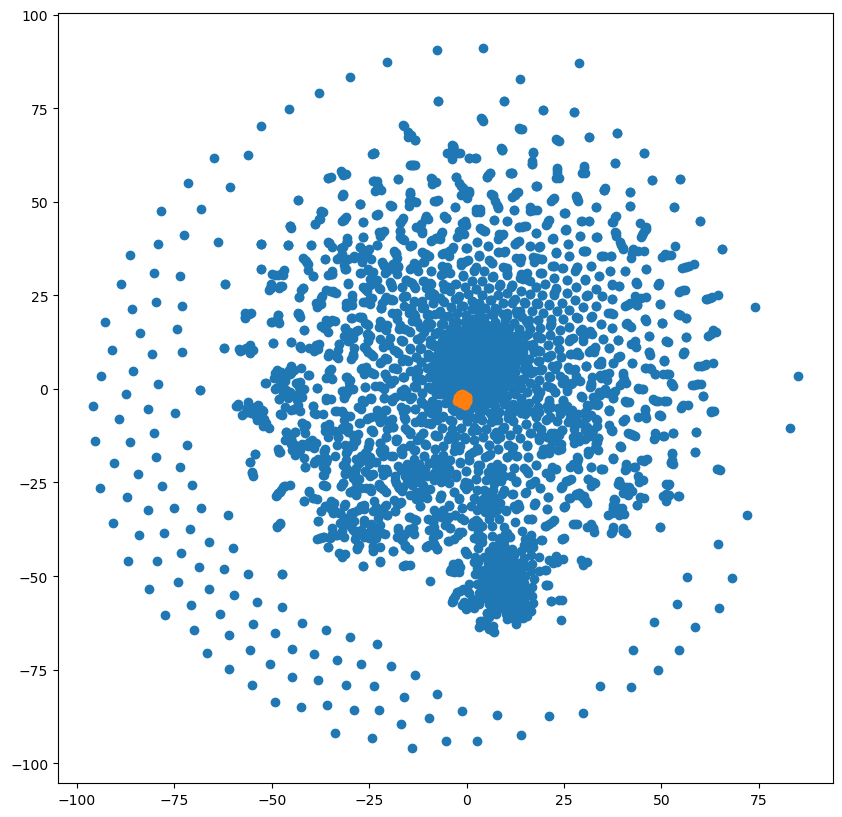

In [32]:
plt.figure(figsize=(10, 10))
# Scatter plot for the word vectors
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], label='fine-tuned w2v')
plt.scatter(w2v_vectors_2d[:, 0], w2v_vectors_2d[:, 1], label='w2v')

# Annotate each point in the scatter plot
for i, word in enumerate(words):
    if word in my_model.wv:
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))
        plt.annotate(word, xy=(w2v_vectors_2d[i, 0], w2v_vectors_2d[i, 1]))

plt.show()